In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
sys.path.append(api_path)

In [3]:
import numpy as np
import random
import sklearn

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F


from sir_ais_sampling import (run_experiments_gaussians,
                              run_experiments_2_gaussians,
                              sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from torch.distributions import (MultivariateNormal, 
                                 Normal, 
                                 Independent, 
                                 Uniform)

from metrics import Evolution
#from utils import DotDict, send_file_to_remote
#from paths import path_to_save_remote, port_to_remote

# SIR, target = 1 gaussian

In [4]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 10000

In [14]:
N = 10
method_params = {'n_steps': n_steps, 'N': N}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent = run_experiments_gaussians(dim_arr,  
                                                scale_proposal, 
                                                scale_target, 
                                                num_points_in_chain, 
                                                strategy_mean,
                                                device,
                                                batch_size,
                                                method_params,
                                                random_seed,
                                                mode_init,
                                                method,
                                                print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 0.9976082444190979
mean estimation of mean = -0.00036224935320205986
mean estimation of ess = 0.2601260126012601
------
dim = 60
mean estimation of variance = 0.9073191285133362
mean estimation of mean = -0.0065486314706504345
mean estimation of ess = 0.0371037103710371
------
dim = 90
mean estimation of variance = 0.9780464172363281
mean estimation of mean = -0.034617263823747635
mean estimation of ess = 0.012201220122012201
------
dim = 120
mean estimation of variance = 3.985846763754353e-09
mean estimation of mean = 0.05003062263131142
mean estimation of ess = 0.0
------
dim = 150
mean estimation of variance = 4.696149247251924e-09
mean estimation of mean = 0.03965234383940697
mean estimation of ess = 0.0
------
dim = 180
mean estimation of variance = 4.668603725832554e-09
mean estimation of mean = 0.059136275202035904
mean estimation of ess = 0.0
------
dim = 210
mean estimation of variance = 4.7978985229235604

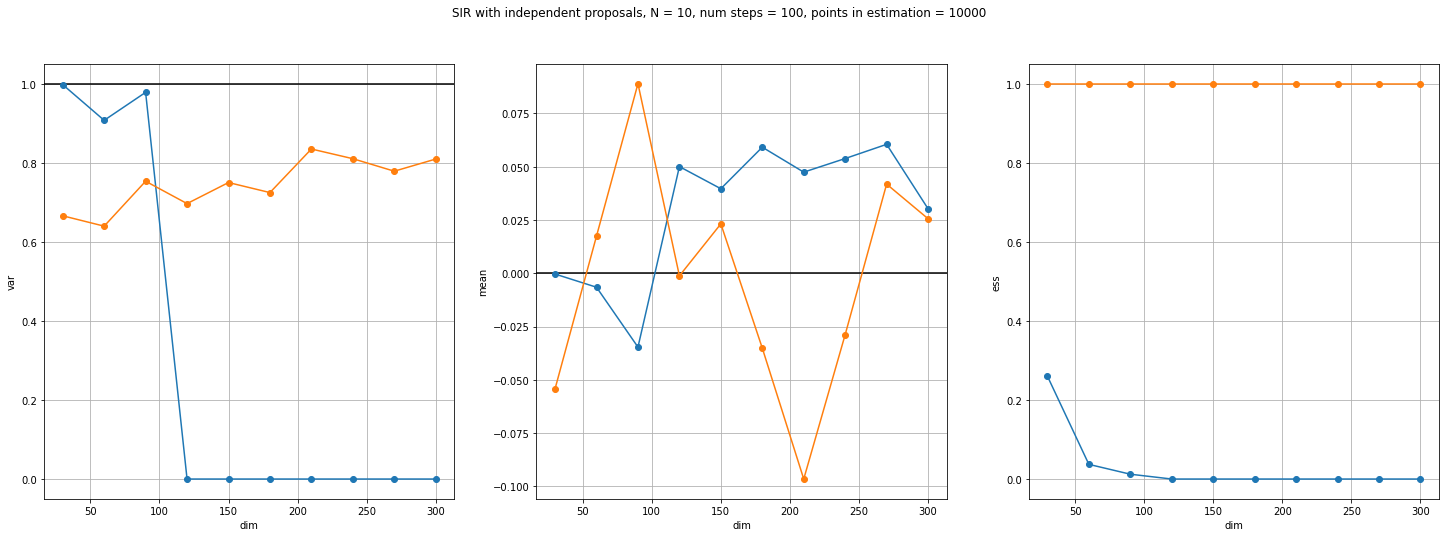

In [26]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')
    axs[i].plot(dim_arr, results_ais['target'][mode], marker='o')

for ax in axs:
    ax.grid()
    #ax.legend()

plt.show()

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_independent_1_gaussian.pdf to remote server....


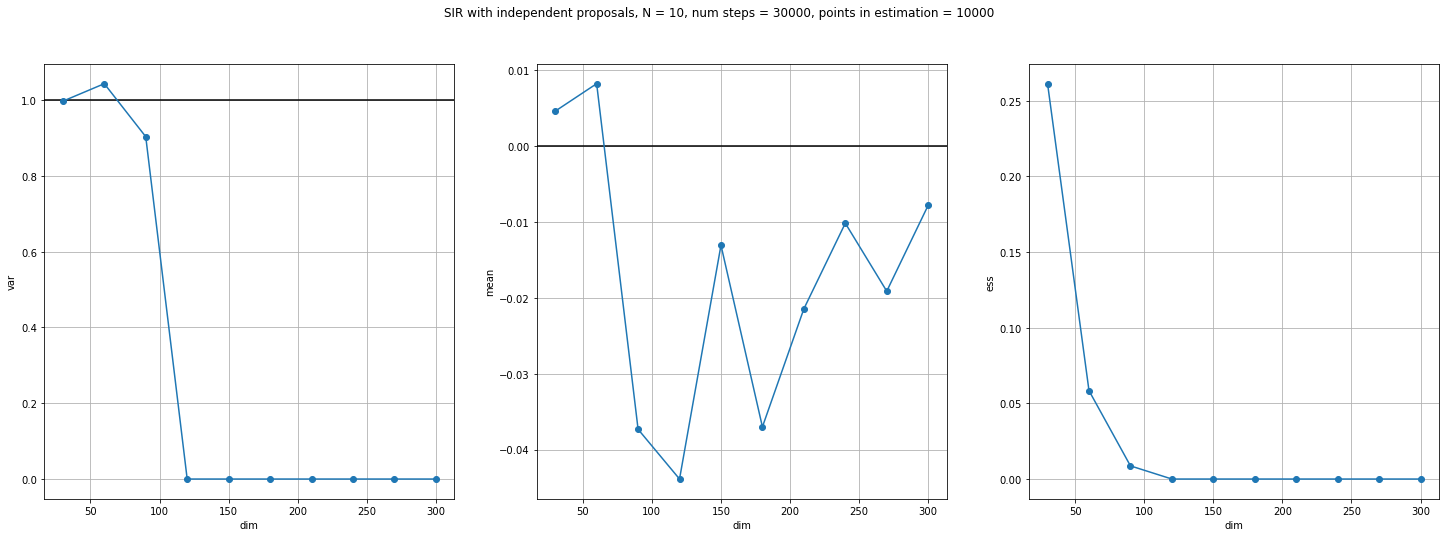

In [78]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')

for ax in axs:
    ax.grid()
    #ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_independent_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)
plt.show()

In [16]:
# fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 55))
# name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
# fig.suptitle(name)

# for i, dim in enumerate(dim_arr):
#     axs[i][0].set_xlabel('MC iter')
#     axs[i][0].set_ylabel('first coord of sample')
#     #axs[i][0].plot(np.arange(len(dict_results['target']['history_first'][i])), 
#     #               dict_results['target']['history_first'][i], 
#     #               label=f'target init', marker='o')
#     axs[i][0].plot(np.arange(len(results_independent['proposal']['history_first'][i])), 
#                    results_independent['proposal']['history_first'][i], 
#                    label=f'proposal init', marker='o')
#     axs[i][0].set_title(f'dim = {dim}')
#     axs[i][0].grid()
#     axs[i][0].legend()

#     axs[i][1].set_xlabel('MC iter')
#     axs[i][1].set_ylabel('norm of sample')
#     #axs[i][1].plot(np.arange(len(dict_results['target']['history_norm'][i])), 
#     #               dict_results['target']['history_norm'][i], 
#     #               label='target init', marker='o')
#     axs[i][1].plot(np.arange(len(results_independent['proposal']['history_norm'][i])), 
#                    results_independent['proposal']['history_norm'][i], 
#                    label=f'proposal init', marker='o')
#     axs[i][1].set_title(f'dim = {dim}')
#     axs[i][1].grid()
#     axs[i][1].legend()


# plt.show()    

In [5]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
mode_init = 'proposal'
results_corr = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         mode_init,
                                         method,
                                         print_results)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.0070724487304688
mean estimation of mean = -0.017963342368602753
mean estimation of ess = 0.849084908490849
------
dim = 60
mean estimation of variance = 0.9941338300704956
mean estimation of mean = -0.015106490813195705
mean estimation of ess = 0.8454845484548454
------
dim = 90
mean estimation of variance = 0.9752694964408875
mean estimation of mean = -0.030947521328926086
mean estimation of ess = 0.847084708470847
------
dim = 120
mean estimation of variance = 0.9907028079032898
mean estimation of mean = -0.012816584669053555
mean estimation of ess = 0.8453845384538454
------
dim = 150
mean estimation of variance = 0.9856138229370117
mean estimation of mean = -0.019321436062455177
mean estimation of ess = 0.8432843284328433
------
dim = 180
mean estimation of variance = 0.9703444838523865
mean estimation of mean = -0.028816070407629013
mean estimation of ess = 0.8481848184818482
------
dim = 210
mean estimat

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_1_gaussian.pdf to remote server....


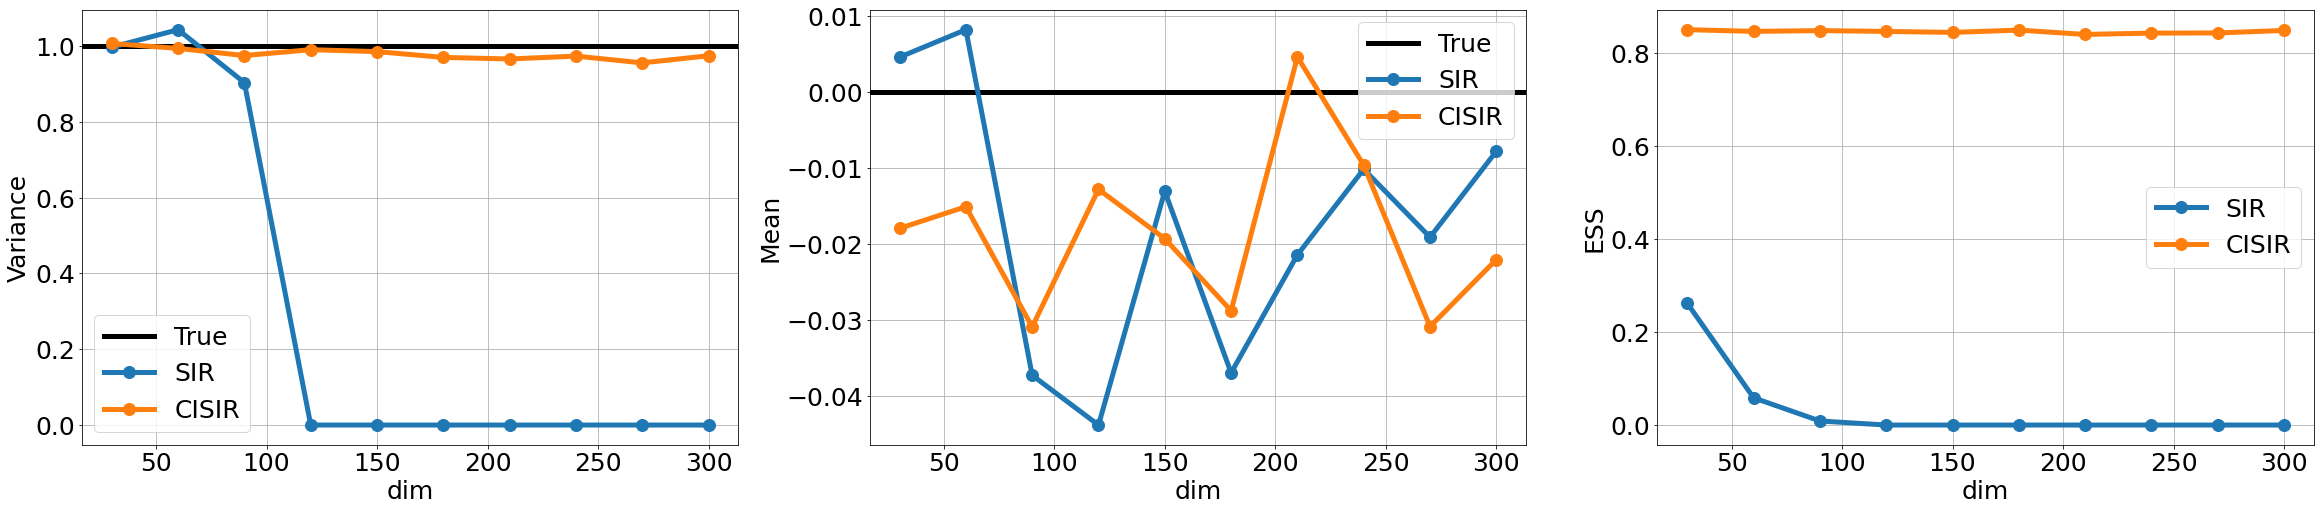

In [51]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(40, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(0.0, label='True', color='black', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_corr['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], label = 'SIR', marker='o',
                markersize = markersize,
                linewidth = linewidth)
    axs[i].plot(dim_arr_corr[:10], results_corr['proposal'][mode][:10], label = 'CISIR', marker='o',
                markersize = markersize,
               linewidth = linewidth)

for ax in axs:
    ax.grid()
    ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)    

plt.show()

In [ ]:
# fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 75))
# name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
# fig.suptitle(name)

# for i, dim in enumerate(dim_arr):
#     axs[i][0].set_xlabel('MC iter')
#     axs[i][0].set_ylabel('first coord of sample')
#     axs[i][0].plot(np.arange(len(results_corr['proposal']['history_first'][i])), 
#                    results_corr['proposal']['history_first'][i], 
#                    label=f'proposal init', marker='o')
#     axs[i][0].set_title(f'dim = {dim}')
#     axs[i][0].grid()
#     axs[i][0].legend()

#     axs[i][1].set_xlabel('MC iter')
#     axs[i][1].set_ylabel('norm of sample')
#     axs[i][1].plot(np.arange(len(results_corr['proposal']['history_norm'][i])), 
#                    results_corr['proposal']['history_norm'][i], 
#                    label='proposal init', marker='o')
#     axs[i][1].set_title(f'dim = {dim}')
#     axs[i][1].grid()
#     axs[i][1].legend()


# plt.show()    

In [81]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 1.0
var_target = 2.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 50000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
mode_init = 'proposal'
results_add = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         mode_init,
                                         method,
                                         print_results)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.9679615497589111
mean estimation of mean = -0.013693430460989475
mean estimation of ess = 0.8473747374737475
------
dim = 60
mean estimation of variance = 1.9376026391983032
mean estimation of mean = 0.0024218917824327946
mean estimation of ess = 0.8488548854885488
------
dim = 90
mean estimation of variance = 1.9066861867904663
mean estimation of mean = 0.007491488475352526
mean estimation of ess = 0.8501650165016501
------
dim = 120
mean estimation of variance = 1.8742953538894653
mean estimation of mean = 0.0036861300468444824
mean estimation of ess = 0.8490849084908489
------
dim = 150
mean estimation of variance = 1.8474078178405762
mean estimation of mean = 0.007857578806579113
mean estimation of ess = 0.8500550055005501
------
dim = 180
mean estimation of variance = 1.8296598196029663
mean estimation of mean = 0.004962598904967308
mean estimation of ess = 0.8501350135013501
------
dim = 210
mean estimati

# SIR, target = 2 gaussians

In [69]:
%autoreload 2

In [6]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
mode_init = 'proposal'
print_results = True
results_corr_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30
mean estimation of target variance = 0.9649330345694039
mean estimation of 1 mode mean  = 1.001739740371704
mean estimation of 2 mode mean  = -1.0066263675689697
mean estimation of JSD  = 0.035398959368467334
mean estimation of HQR  = 0.9492499947547912
mean estimation of ESS = 0.7905590559055906
------
dim = 60
mean estimation of target variance = 0.9684273057532629
mean estimation of 1 mode mean  = 0.997853696346283
mean estimation of 2 mode mean  = -1.0056425333023071
mean estimation of JSD  = 0.03554243594408035
mean estimation of HQR  = 0.9503100037574768
mean estimation of ESS = 0.7908890889088909
------
dim = 90
mean estimation of target variance = 0.9752672240779294
mean estimation of 1 mode mean  = 0.9903038740158081
mean estimation of 2 mode mean  = -1.0032496452331543
mean estimation of JSD  = 0.03547200188040733
mean estimation of HQR  = 0.9497600018978118
mean estimation of ESS = 0.7934193419341935
------
dim = 120
mean estimatio

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_correlated_2_gaussians.pdf to remote server....


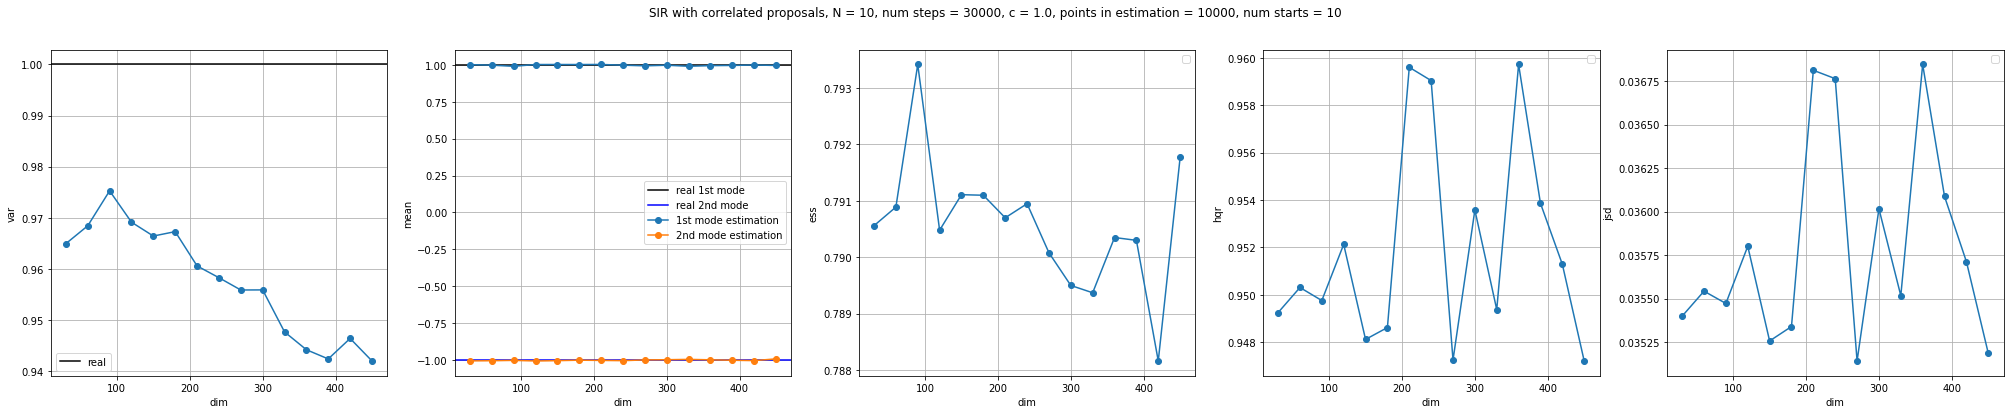

In [71]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(35, 6))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(loc_1_target, label='real 1st mode', color='black')
axs[1].axhline(loc_2_target, label='real 2nd mode', color='blue')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('hqr')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('jsd')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_1'], 
        #            label='target init, 1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_1'], 
                    label='1st mode estimation', marker='o')
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_2'], 
                    label='2nd mode estimation', marker='o')
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        #axs[j].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
        axs[j].plot(dim_arr, results_corr_2['proposal'][mode], marker='o')
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_correlated_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()

In [7]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent_2 = run_experiments_2_gaussians(dim_arr,  
                                                    scale_proposal, 
                                                    scale_target,
                                                    loc_1_target,
                                                    loc_2_target,
                                                    num_points_in_chain, 
                                                    strategy_mean,
                                                    device,
                                                    batch_size,
                                                    method_params,
                                                    random_seed,
                                                    mode_init,
                                                    method,
                                                    print_results)

------------------
mode = target
dim = 30
mean estimation of target variance = 0.5177300910103673
mean estimation of 1 mode mean  = 0.8630160093307495
mean estimation of 2 mode mean  = -0.8818822503089905
mean estimation of JSD  = 0.044360130093991756
mean estimation of HQR  = 0.9425499975681305
mean estimation of ESS = 0.0037703770377037703
------
dim = 60
mean estimation of target variance = 7.373292264391776e-14
mean estimation of 1 mode mean  = 0.9944514036178589
mean estimation of 2 mode mean  = -1.0214898586273193
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 90
mean estimation of target variance = 7.426876359800128e-14
mean estimation of 1 mode mean  = 1.01462721824646
mean estimation of 2 mode mean  = -0.9778567552566528
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 120
mean estimation of target variance = 7.118772735836129e-14
mean est

In [9]:
dim_arr_corr = [30*(i + 1) for i in range(15)]

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_2_gaussians.pdf to remote server....


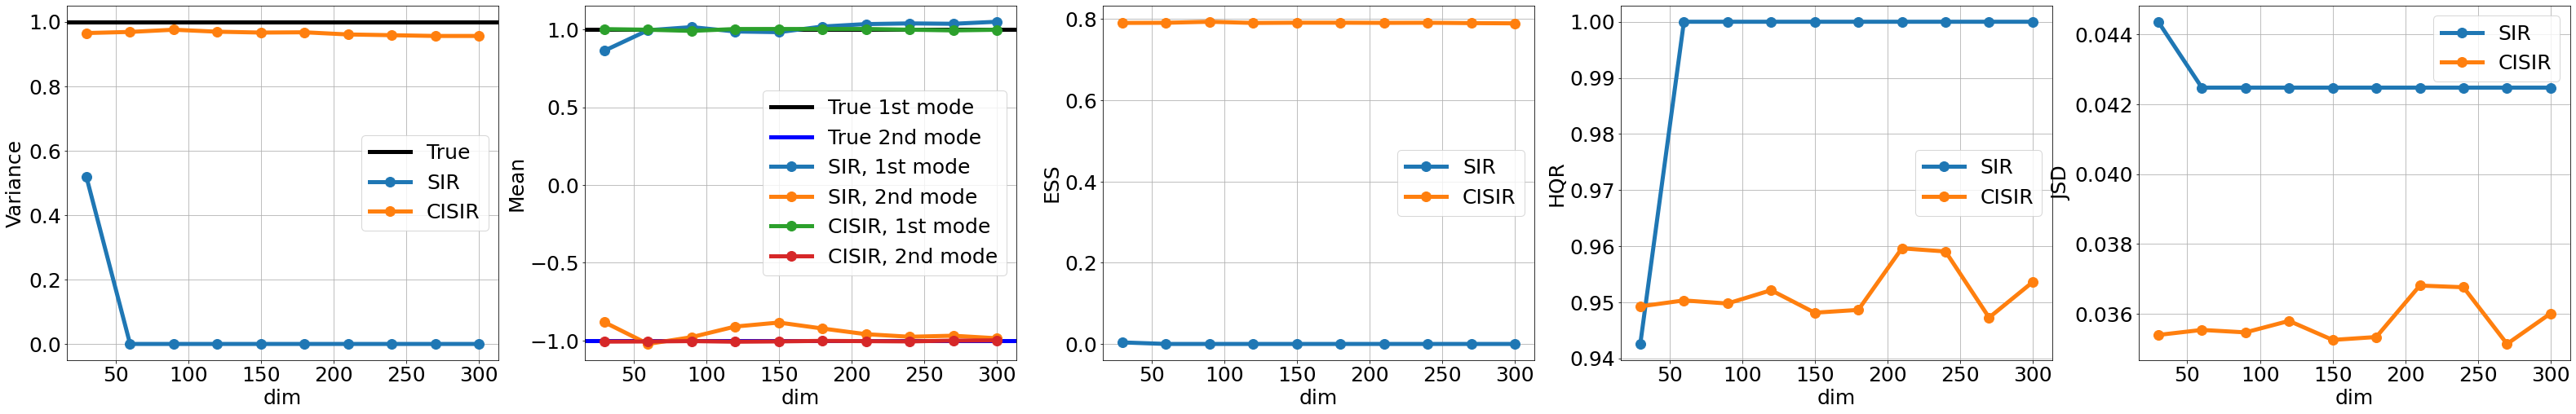

In [50]:
plt.rcParams.update({'font.size': 25})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(55, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(loc_1_target, label='True 1st mode', color='black', linewidth = linewidth)
axs[1].axhline(loc_2_target, label='True 2nd mode', color='blue', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('JSD')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_1'], 
                    label='SIR, 1st mode', marker='o', linewidth = linewidth, 
                   markersize = markersize )
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_2'], 
                    label='SIR, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr_corr[:10], results_corr_2['proposal']['mean_loc_1'][:10], 
                    label='CISIR, 1st mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr_corr[:10], results_corr_2['proposal']['mean_loc_2'][:10], 
                    label='CISIR, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_independent_2['target'][mode], 
                    label='SIR', marker='o', linewidth = linewidth,
                   markersize  = markersize)
        axs[j].plot(dim_arr_corr[:10], results_corr_2['proposal'][mode][:10], 
                    label='CISIR', marker='o', linewidth = linewidth,
                   markersize  = markersize)
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()

# AIS

In [31]:
dim_arr = [2] + [30*(i + 1) for i in range(9)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 500
strategy_mean = 'starts' #'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 1000
n_steps = 2000 #5000

In [11]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True
results_ais_z = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed,
                                        mode_init,
                                        method,
                                        print_results)

------------------
mode = proposal
dim = 2
mean estimation of variance = 0.7536907196044922
mean estimation of mean = -0.015722453594207764
mean estimation of ess = 1.0
------
dim = 30
mean estimation of variance = 0.7957371473312378
mean estimation of mean = -0.00468123285099864
mean estimation of ess = 1.0
------
dim = 60
mean estimation of variance = 0.8569926619529724
mean estimation of mean = -0.0019912724383175373
mean estimation of ess = 1.0
------
dim = 90
mean estimation of variance = 0.9127068519592285
mean estimation of mean = 0.002895156154409051
mean estimation of ess = 1.0
------
dim = 120
mean estimation of variance = 0.9647735357284546
mean estimation of mean = 0.0014874235494062304
mean estimation of ess = 1.0
------
dim = 150
mean estimation of variance = 1.009746789932251
mean estimation of mean = 0.0022969224955886602
mean estimation of ess = 1.0
------
dim = 180
mean estimation of variance = 1.05258309841156
mean estimation of mean = 0.0016128624556586146
mean esti

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5
rho = 0.99

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True
results_ais_v = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed,
                                        mode_init,
                                        method,
                                        print_results)

------------------
mode = proposal
dim = 2
mean estimation of variance = 0.8087701201438904
mean estimation of mean = -0.02311437949538231
mean estimation of ess = 1.0
------
dim = 30
mean estimation of variance = 0.8715639710426331
mean estimation of mean = 0.000812058337032795
mean estimation of ess = 1.0
------
dim = 60
mean estimation of variance = 0.9228194952011108
mean estimation of mean = -0.0010011657141149044
mean estimation of ess = 1.0
------
dim = 90


KeyboardInterrupt: 

In [32]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5
rho = 0.99

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_b' 
mode_init = 'proposal'
print_results = True
results_ais_b = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed,
                                        mode_init,
                                        method,
                                        print_results)

------------------
mode = proposal
dim = 2
mean estimation of variance = 0.9535551071166992
mean estimation of mean = -0.002696871291846037
mean estimation of ess = 1.0
------
dim = 30
mean estimation of variance = 1.0443822145462036
mean estimation of mean = 0.0007226467132568359
mean estimation of ess = 1.0
------
dim = 60
mean estimation of variance = 1.1303502321243286
mean estimation of mean = 0.0006734917405992746
mean estimation of ess = 1.0
------
dim = 90
mean estimation of variance = 1.1953366994857788
mean estimation of mean = -8.397811325266957e-05
mean estimation of ess = 1.0
------
dim = 120
mean estimation of variance = 1.2464741468429565
mean estimation of mean = 0.0009483674657531083
mean estimation of ess = 1.0
------
dim = 150
mean estimation of variance = 1.2872951030731201
mean estimation of mean = -0.000316557299811393
mean estimation of ess = 1.0
------
dim = 180
mean estimation of variance = 1.319182276725769
mean estimation of mean = -1.7914766431204043e-05
mea

In [11]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5
rho = 0.99

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_b' 
mode_init = 'proposal'
print_results = True
results_ais_b = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed,
                                        mode_init,
                                        method,
                                        print_results)

------------------
mode = proposal
dim = 2
mean estimation of variance = 0.9978063702583313
mean estimation of mean = 0.004881377797573805
mean estimation of ess = 1.0
------
dim = 30
mean estimation of variance = 1.1116199493408203
mean estimation of mean = -0.002176809823140502
mean estimation of ess = 1.0
------
dim = 60
mean estimation of variance = 1.1861463785171509
mean estimation of mean = 0.008332925848662853
mean estimation of ess = 1.0
------
dim = 90
mean estimation of variance = 1.2450612783432007
mean estimation of mean = 0.007688639685511589
mean estimation of ess = 1.0
------
dim = 120


KeyboardInterrupt: 

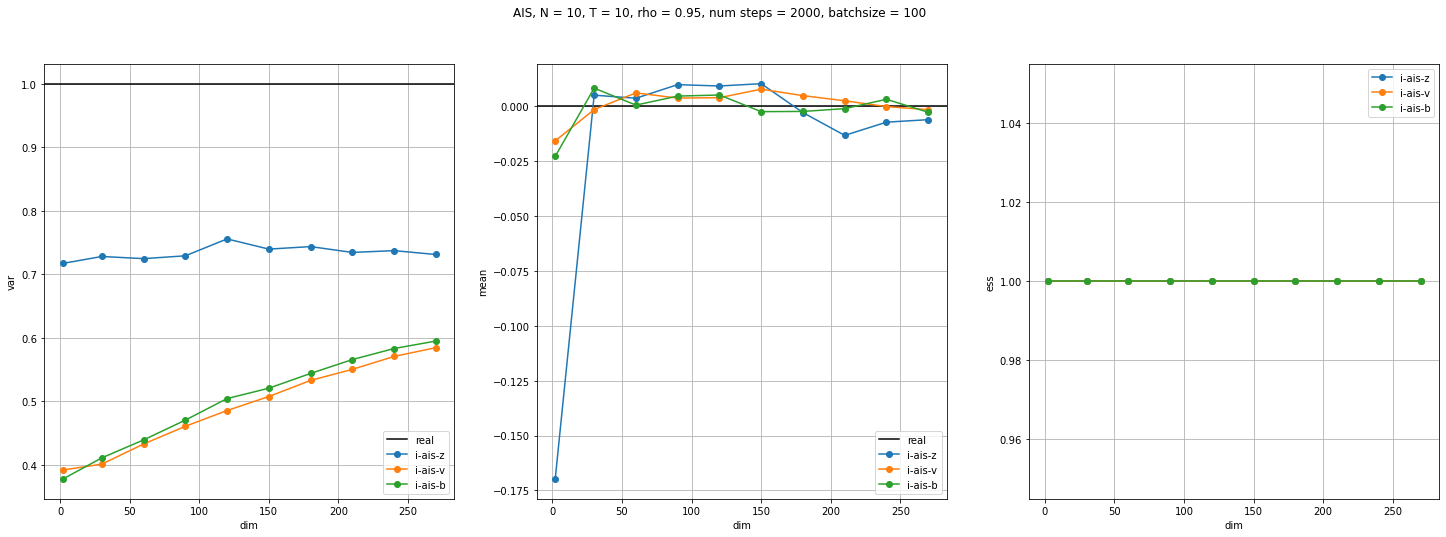

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}, T = {T}, rho = {rho}, num steps = {n_steps}, batchsize = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    #axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')
    # axs[i].plot(dim_arr, results_ais['proposal'][mode], marker='o', label='ais')
    axs[i].plot(dim_arr, results_ais_z['proposal'][mode], marker='o', label='i-ais-z')
    axs[i].plot(dim_arr, results_ais_v['proposal'][mode], marker='o', label='i-ais-v')
    axs[i].plot(dim_arr, results_ais_b['proposal'][mode], marker='o', label='i-ais-b')
    # axs[i].plot(dim_arr, results_cais['proposal'][mode], marker='o', label='cais')

for ax in axs:
    ax.grid()
    ax.legend()

plt.savefig('../../fig.png')
plt.show()

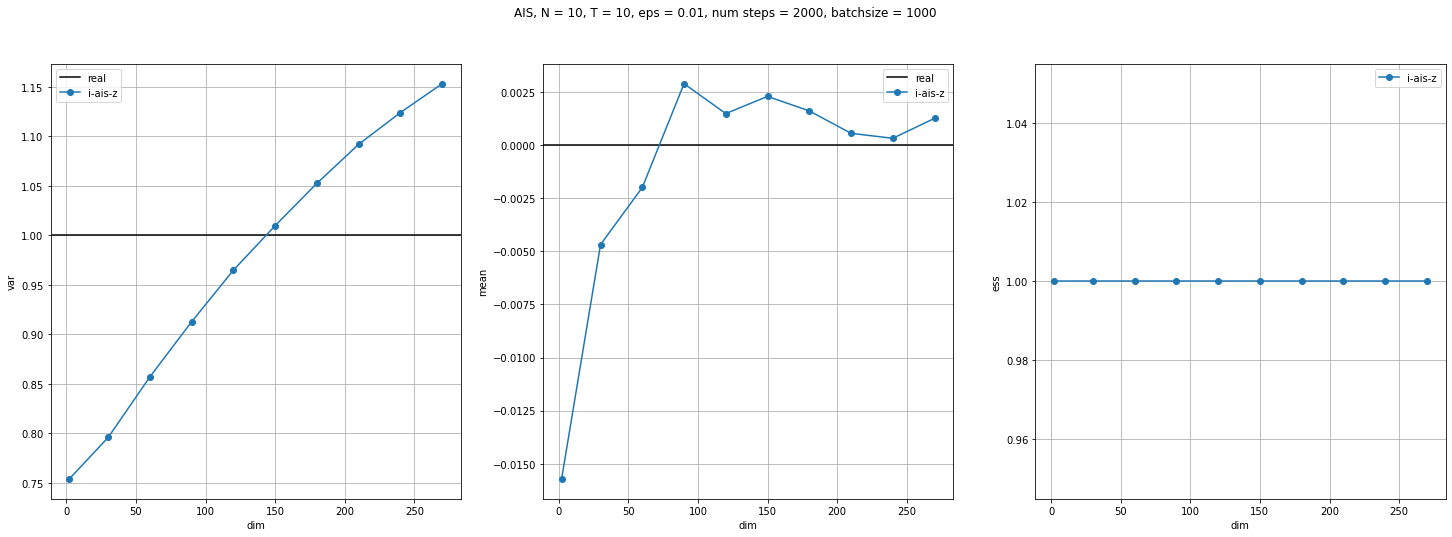

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}, T = {T}, eps = {grad_step}, num steps = {n_steps}, batchsize = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    #axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')
    # axs[i].plot(dim_arr, results_ais['proposal'][mode], marker='o', label='ais')
    axs[i].plot(dim_arr, results_ais_z['proposal'][mode], marker='o', label='i-ais-z')
    # axs[i].plot(dim_arr, results_cais['proposal'][mode], marker='o', label='cais')

for ax in axs:
    ax.grid()
    ax.legend()

#plt.savefig('../../fig.png')
plt.show()

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
N = 10

T = 10
betas = np.linspace(1., 0., T)
rhos = np.linspace(.8, 1., T)[::-1]

grad_step = 1e-3
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rhos': rhos}
random_seed = 42
method = 'ais' 
mode_init = 'proposal'
print_results = True
device = 'cpu'
results_cais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed,
                                        mode_init,
                                        method,
                                        print_results)

  0%|          | 0/500 [00:00<?, ?it/s]

------------------
mode = proposal
dim = 30


  1%|          | 3/500 [00:00<00:22, 22.58it/s]

mean estimation of variance = 0.7013007998466492
mean estimation of mean = -0.03162836283445358
mean estimation of ess = 0.09699999999999999
------
dim = 60


  1%|          | 3/500 [00:00<00:20, 23.71it/s]

mean estimation of variance = 0.8623953461647034
mean estimation of mean = 0.01752980798482895
mean estimation of ess = 0.013199999999999998
------
dim = 90


  1%|          | 3/500 [00:00<00:21, 22.95it/s]

mean estimation of variance = 1.2264103889465332
mean estimation of mean = 6.82759637129493e-05
mean estimation of ess = 0.0142
------
dim = 120


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


mean estimation of variance = 1.7159042358398438
mean estimation of mean = 0.014558002352714539
mean estimation of ess = 0.0062
------
dim = 150


100%|██████████| 500/500 [00:38<00:00, 12.87it/s]


mean estimation of variance = 1.8893839120864868
mean estimation of mean = 0.004559800028800964
mean estimation of ess = 0.0030000000000000005
------
dim = 180


  1%|          | 3/500 [00:00<00:21, 23.60it/s]

mean estimation of variance = 1.9499633312225342
mean estimation of mean = 0.0246374923735857
mean estimation of ess = 0.0002
------
dim = 210


 78%|███████▊  | 390/500 [00:28<00:07, 13.76it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 3.95 GiB total capacity; 3.18 GiB already allocated; 2.25 MiB free; 3.64 GiB reserved in total by PyTorch)

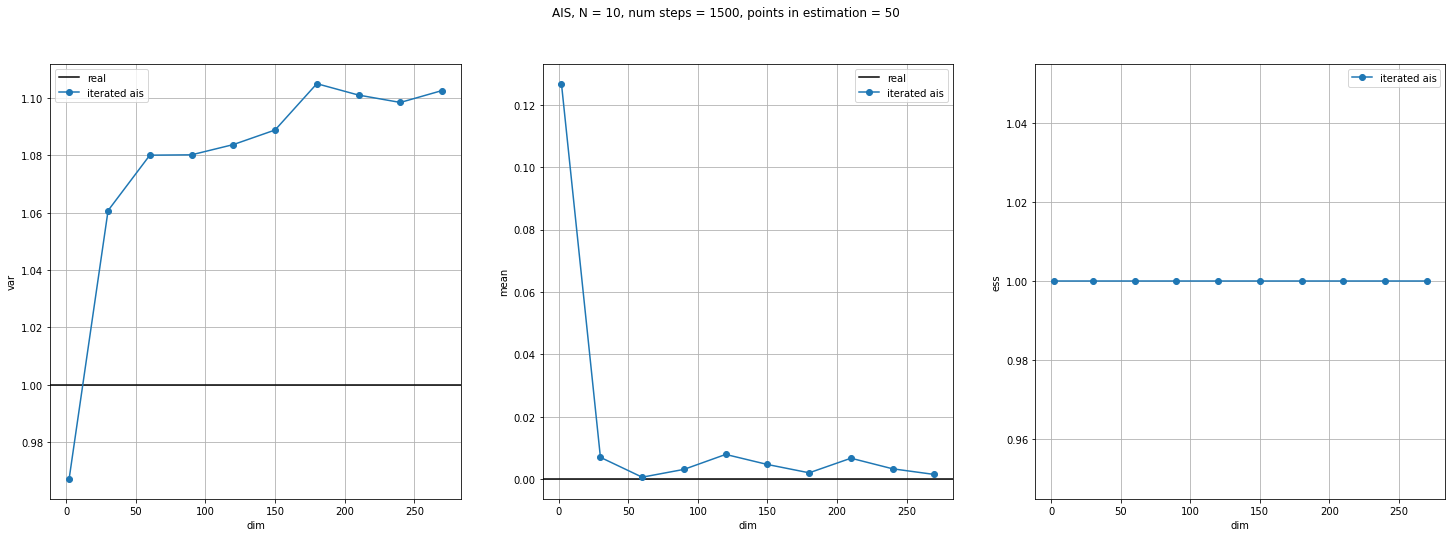

In [46]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}, num steps = {1500}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    #axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')
    # axs[i].plot(dim_arr, results_ais['proposal'][mode], marker='o', label='ais')
    axs[i].plot(dim_arr, results_iterated_ais['proposal'][mode], marker='o', label='iterated ais')
    # axs[i].plot(dim_arr, results_cais['proposal'][mode], marker='o', label='cais')

for ax in axs:
    ax.grid()
    ax.legend()

plt.savefig('../../fig.png')
plt.show()

In [18]:
dim_arr = [30*(i + 1) for i in range(9)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 1
n_steps = 5000
batch_size = 1000
strategy_mean = 'starts'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True
results_ais_z_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30
mean estimation of target variance = 0.7937831710361061
mean estimation of 1 mode mean  = 0.9985363483428955
mean estimation of 2 mode mean  = -1.0001285076141357
mean estimation of JSD  = 4.337697755545378e-06
mean estimation of HQR  = 0.9970700013637542
mean estimation of ESS = 1.0
------
dim = 60
mean estimation of target variance = 0.8545974757342905
mean estimation of 1 mode mean  = 0.9966831207275391
mean estimation of 2 mode mean  = -1.0010838508605957
mean estimation of JSD  = 0.0003618617495521903
mean estimation of HQR  = 0.9970900011062622
mean estimation of ESS = 1.0
------
dim = 90
mean estimation of target variance = 0.9099056266383744
mean estimation of 1 mode mean  = 1.0008113384246826
mean estimation of 2 mode mean  = -0.9991840124130249
mean estimation of JSD  = 0.0005218910658732057
mean estimation of HQR  = 0.9937599986791611
mean estimation of ESS = 1.0
------
dim = 120
mean estimation of target variance = 0.9577946945566

KeyboardInterrupt: 

In [19]:
N = 5

T = 5
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5
rho = 0.99

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True
results_ais_v_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30


/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/sir_ais_sampling.py:766: RuntimeWarning: Mean of empty slice.
  ess_bs = (diff != dim).mean(axis = 0)
/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


mean estimation of target variance = 0.45486219352415347
mean estimation of 1 mode mean  = 0.5893497467041016
mean estimation of 2 mode mean  = -0.6049059629440308
mean estimation of JSD  = 8.223927579820156e-06
mean estimation of HQR  = 1.0
mean estimation of ESS = nan
------
dim = 60


KeyboardInterrupt: 

In [7]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5
rho = 0.99

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_b' 
mode_init = 'proposal'
print_results = True
results_ais_b_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30
mean estimation of target variance = 1.173247130799261
mean estimation of 1 mode mean  = 0.9937506914138794
mean estimation of 2 mode mean  = -0.9927588701248169
mean estimation of JSD  = 0.019698219738900662
mean estimation of HQR  = 0.6427200002670288
mean estimation of ESS = 1.0
------
dim = 60
mean estimation of target variance = 1.1910915281493222
mean estimation of 1 mode mean  = 0.9950418472290039
mean estimation of 2 mode mean  = -0.9917668700218201
mean estimation of JSD  = 0.12274662317335605
mean estimation of HQR  = 0.24587399926781656
mean estimation of ESS = 1.0
------
dim = 90
mean estimation of target variance = 1.1808166888389693
mean estimation of 1 mode mean  = 0.9935846328735352
mean estimation of 2 mode mean  = -0.994761049747467
mean estimation of JSD  = 0.2473857600390911
mean estimation of HQR  = 0.06487200029939413
mean estimation of ESS = 1.0
------
dim = 120


KeyboardInterrupt: 

In [ ]:
plt.rcParams.update({'font.size': 15})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(55, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(loc_1_target, label='True 1st mode', color='black', linewidth = linewidth)
axs[1].axhline(loc_2_target, label='True 2nd mode', color='blue', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('JSD')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_ais_z_2['proposal']['mean_loc_1'], 
                    label='i-ais-z, 1st mode', marker='o', linewidth = linewidth, 
                   markersize = markersize )
        axs[i].plot(dim_arr, results_ais_z_2['proposal']['mean_loc_2'], 
                    label='i-ais-z, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr, results_ais_v_2['proposal']['mean_loc_1'], 
                    label='i-ais-v, 1st mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_ais_v_2['proposal']['mean_loc_2'], 
                    label='i-ais-v, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_ais_z_2['proposal'][mode], 
                    label='i-ais-z', marker='o', linewidth = linewidth,
                   markersize  = markersize)
        axs[j].plot(dim_arr, results_ais_v_2['proposal'][mode], 
                    label='i-ais-v', marker='o', linewidth = linewidth,
                   markersize  = markersize)
    
for ax in axs:
    ax.grid()
    ax.legend()

plt.savefig('../../fig.png')
plt.show()

In [58]:
N = 10
T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-3
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas}

random_seed = 42
method = 'vanilla_ais' 
mode_init = 'proposal'
print_results = True
results_ais_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30
mean estimation of target variance = 0.8841040056604585
mean estimation of 1 mode mean  = 1.0044653415679932
mean estimation of 2 mode mean  = -1.0038338899612427
mean estimation of JSD  = 0.00013258838327601552
mean estimation of HQR  = 0.9804000109434128
mean estimation of ESS = 1.0
------
dim = 60
mean estimation of target variance = 0.8853655574823608
mean estimation of 1 mode mean  = 1.0135178565979004
mean estimation of 2 mode mean  = -0.9904456734657288
mean estimation of JSD  = 0.0004628732893615961
mean estimation of HQR  = 0.9885000103712082
mean estimation of ESS = 1.0
------
dim = 90
mean estimation of target variance = 0.9402160455090035
mean estimation of 1 mode mean  = 0.9939209222793579
mean estimation of 2 mode mean  = -0.9920096397399902
mean estimation of JSD  = 0.0002766214613802731
mean estimation of HQR  = 0.9858000129461288
mean estimation of ESS = 1.0
------
dim = 120
mean estimation of target variance = 0.945959382957

In [14]:
N = 10
T = 5
betas = np.linspace(1., 0., T)
rhos = np.linspace(.8, 1, T)[::-1]

grad_step = 1e-3
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rhos': rhos}

random_seed = 42
method = 'ais' 
mode_init = 'proposal'
print_results = True
results_cais_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

  0%|          | 3/1000 [00:00<00:36, 27.60it/s]------------------
mode = proposal
dim = 30
  0%|          | 3/1000 [00:00<00:41, 23.98it/s]mean estimation of target variance = 0.703576331234803
mean estimation of 1 mode mean  = 0.7116298675537109
mean estimation of 2 mode mean  = -0.7007265686988831
mean estimation of JSD  = 0.00036160531686618924
mean estimation of HQR  = 0.9981000018119812
mean estimation of ESS = 0.04676767676767676
------
dim = 60
  0%|          | 2/1000 [00:00<00:54, 18.27it/s]mean estimation of target variance = 0.8454396182670817
mean estimation of 1 mode mean  = 0.6403836607933044
mean estimation of 2 mode mean  = -0.6016232371330261
mean estimation of JSD  = 2.697406802326441e-05
mean estimation of HQR  = 0.9894000101089477
mean estimation of ESS = 0.005959595959595959
------
dim = 90
  0%|          | 2/1000 [00:00<01:03, 15.84it/s]mean estimation of target variance = 1.0047874100432441
mean estimation of 1 mode mean  = 0.6129814386367798
mean estimation of 2

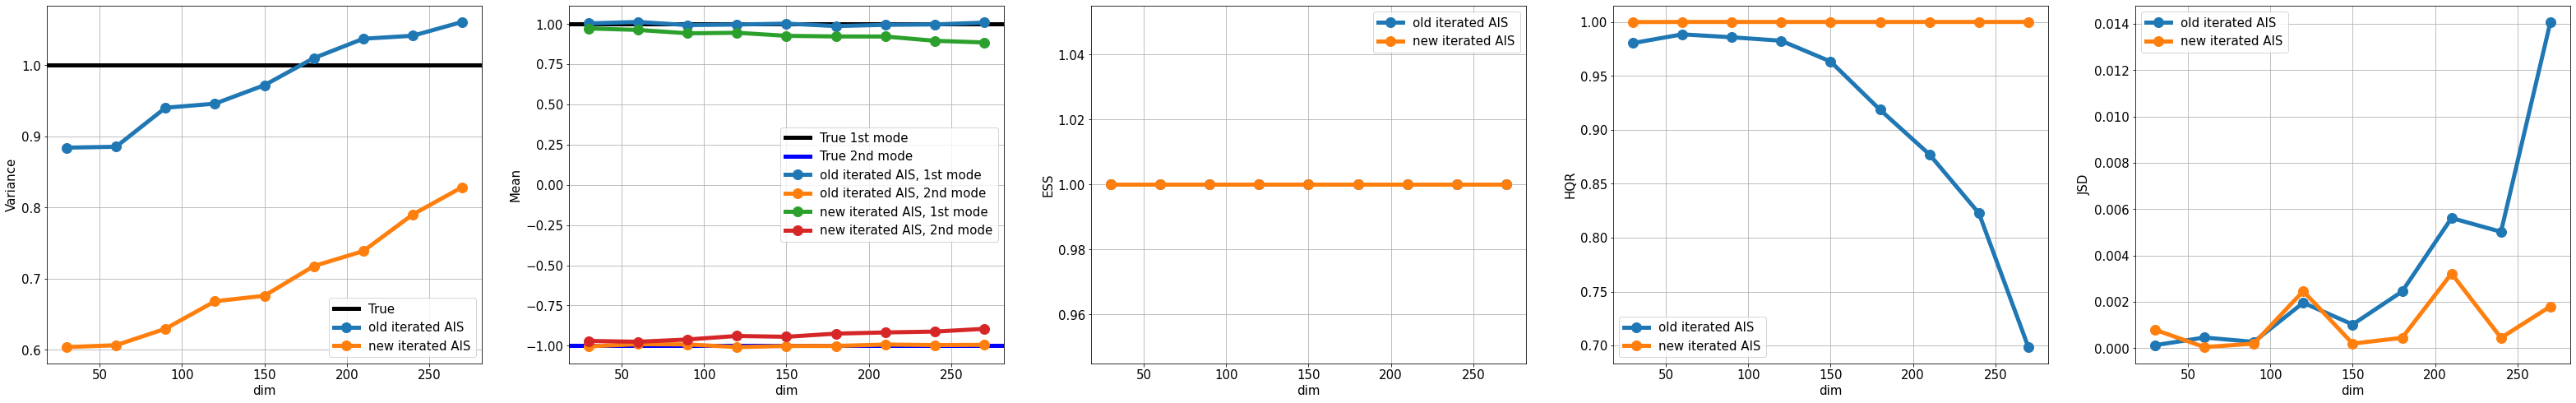

In [59]:
plt.rcParams.update({'font.size': 15})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(55, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(loc_1_target, label='True 1st mode', color='black', linewidth = linewidth)
axs[1].axhline(loc_2_target, label='True 2nd mode', color='blue', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('JSD')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_ais_2['proposal']['mean_loc_1'], 
                    label='old iterated AIS, 1st mode', marker='o', linewidth = linewidth, 
                   markersize = markersize )
        axs[i].plot(dim_arr, results_ais_2['proposal']['mean_loc_2'], 
                    label='old iterated AIS, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr, results_iterated_ais['proposal']['mean_loc_1'], 
                    label='new iterated AIS, 1st mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_iterated_ais['proposal']['mean_loc_2'], 
                    label='new iterated AIS, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_ais_2['proposal'][mode], 
                    label='old iterated AIS', marker='o', linewidth = linewidth,
                   markersize  = markersize)
        axs[j].plot(dim_arr, results_iterated_ais['proposal'][mode], 
                    label='new iterated AIS', marker='o', linewidth = linewidth,
                   markersize  = markersize)
    
for ax in axs:
    ax.grid()
    ax.legend()

plt.savefig('../../fig.png')
plt.show()

In [21]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3 
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.5975260936156033e-13
mean estimation of mean = 0.00031487346859648824
mean estimation of ess = 0.0
------
dim = 60
mean estimation of variance = 3.8437390206466637e-13
mean estimation of mean = -0.24517042934894562
mean estimation of ess = 0.0
------
dim = 90


KeyboardInterrupt: 

In [23]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-5
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 0.40736278891563416
mean estimation of mean = 0.09033182263374329
mean estimation of ess = 0.0707070707070707
------
dim = 60
mean estimation of variance = 3.163713594486056e-13
mean estimation of mean = -0.013153579086065292
mean estimation of ess = 0.0
------
dim = 90
mean estimation of variance = 0.05793793871998787
mean estimation of mean = 0.14050395786762238
mean estimation of ess = 0.010101010101010102
------
dim = 120
mean estimation of variance = 4.778340266867187e-13
mean estimation of mean = -0.018784768879413605
mean estimation of ess = 0.0
------
dim = 150


KeyboardInterrupt: 

In [24]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-6
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 0.4055508077144623
mean estimation of mean = 0.09060540050268173
mean estimation of ess = 0.0707070707070707
------
dim = 60
mean estimation of variance = 5.901754779324975e-13
mean estimation of mean = -0.01401237491518259
mean estimation of ess = 0.0
------
dim = 90
mean estimation of variance = 0.057806555181741714
mean estimation of mean = 0.14042149484157562
mean estimation of ess = 0.010101010101010102
------
dim = 120
mean estimation of variance = 4.237722911297481e-13
mean estimation of mean = -0.008704849518835545
mean estimation of ess = 0.0
------
dim = 150
mean estimation of variance = 5.327746707348147e-13
mean estimation of mean = 0.13015666604042053
mean estimation of ess = 0.0
------
dim = 180
mean estimation of variance = 0.418191522359848
mean estimation of mean = 0.013513946905732155
mean estimation of ess = 0.020202020202020204
------
dim = 210
mean estimation of variance = 6.880657610515428e-

KeyboardInterrupt: 

In [25]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 2.7802673358001684e-13
mean estimation of mean = 0.04109269753098488
mean estimation of ess = 0.0
------
dim = 60


KeyboardInterrupt: 

In [105]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 1000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 10000
c = 1.0
N = 10
p0 = 0.95
p = 0.95
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])

grad_step = 1e-3
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'p0': p0, 
                 'p': p, 
                 'betas': betas, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.558164358139038
mean estimation of mean = -0.014803966507315636
mean estimation of ess = 0.3963963963963964
------
dim = 60


KeyboardInterrupt: 